# Canopy RT module (rewrite from mSCOPE)
---
### Can use different leaf properties per layer, but can be boiled down to a simpler version as well. Some examples shown here.
---
To be looked at here:
Computer leaf optical properties for standard values
Compute canopy radiation (both reflectance as well as within canopy distributions for SW energy balance).


In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
pyplot()

Plots.PyPlotBackend()

In [2]:
using CanopyRTMod
using BenchmarkTools
using Statistics

In [3]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

---
Define the different leaf properties per layer in an array of leaves, can be simplified later if we want to. Right now, I just re-use the same leaf everywhere

In [4]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end
# This actually almost takes 1ms!
#CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)


---
## Perform 4 separate steps towards canopy SW RT

#### Compute canopy geometric properties (entirely dependent on LAI and leaf angular distributions)

In [5]:
CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)

#### Compute layer optical properties (includes leaf reflectance and transmittance now)

In [6]:
CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

#### Compute SW radiation transfer via mSCOPE approach

In [7]:
@btime CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);

  89.644 μs (483 allocations: 304.05 KiB)


  825.023 μs (3201 allocations: 1.94 MiB)


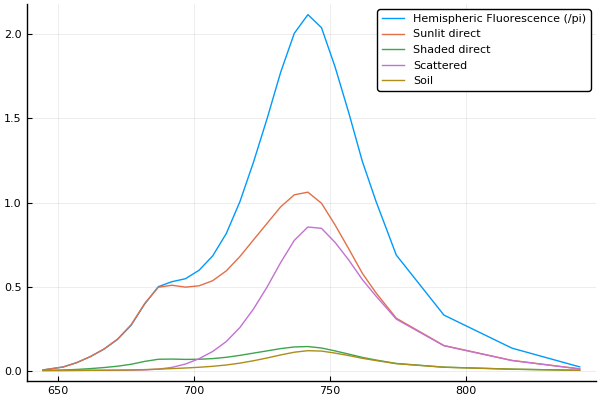

In [8]:
@time CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
#piLo1, piLo2, piLo3, piLo4, F⁻,F⁺,S⁻,S⁺,piLs, piLd =
#println(size(piLs))
#plot(wlf, piLs)
plot(wlf, canRad.SIF_hemi/pi, label="Hemispheric Fluorescence (/pi)")
plot!(wlf, canRad.SIF_obs_sunlit, label="Sunlit direct")
plot!(wlf, canRad.SIF_obs_shaded, label="Shaded direct")
plot!(wlf, canRad.SIF_obs_scattered, label="Scattered")
plot!(wlf, canRad.SIF_obs_soil, label="Soil")

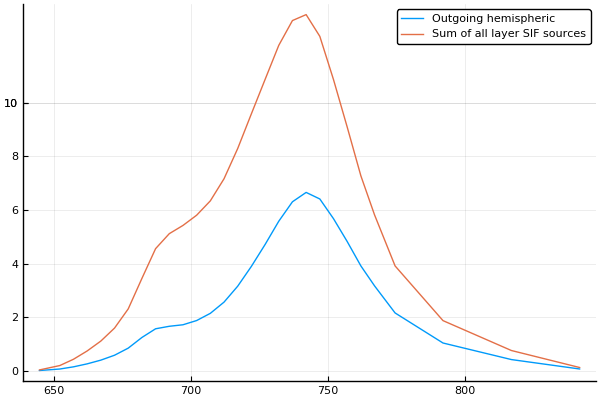

In [9]:
plot(wlf, canRad.SIF_hemi, label="Outgoing hemispheric")
plot!(wlf, canRad.SIF_sum, label="Sum of all layer SIF sources")


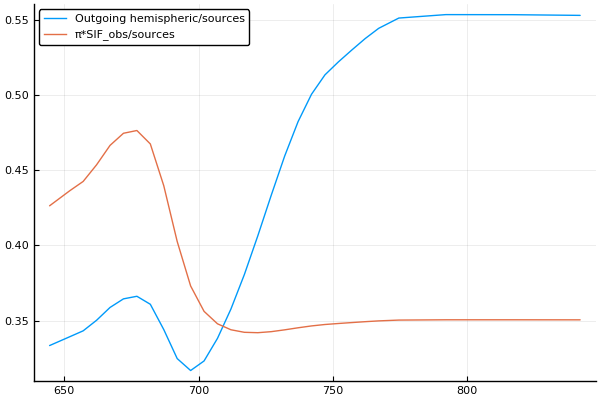

In [10]:
plot(wlf, canRad.SIF_hemi./canRad.SIF_sum, label="Outgoing hemispheric/sources")
plot!(wlf, pi*canRad.SIF_obs./canRad.SIF_sum, label="π*SIF_obs/sources")
#plot!(wlf, , label="Sum of all layer SIF sources")

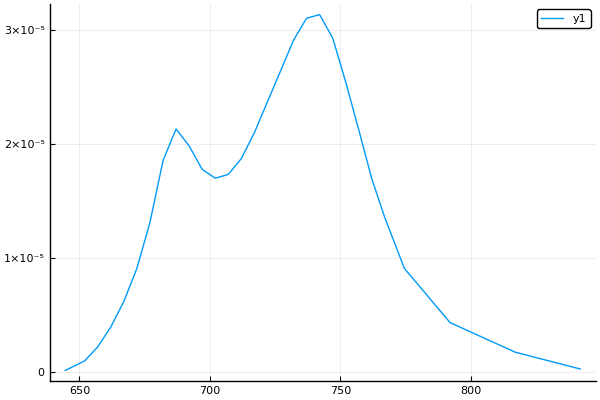

In [11]:
plot(wlf, arrayOfLeaves[1].Mb[:,1])

In [12]:
iLAI = canopy.LAI/canopy.nlayers
ϵ = zeros(20).+0.98
fSun = (canOpt.Ps[1:20]+canOpt.Ps[2:21])/2
wlii = [10]
S⁺,S⁻ = CanopyRTMod.computeThermalFluxes(canRad.T_shade, canRad.T_sun, ϵ, iLAI, canopy.lidf, fSun, wlii)
#plot(S⁺)

UndefVarError: UndefVarError: computeThermalFluxes not defined

#### Compute all derived fluxes necessary for Photosynthesis and radiation balance 

In [13]:
@btime CanopyRTMod.deriveCanopyFluxes!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil, arrayOfLeaves);

  82.361 μs (586 allocations: 268.75 KiB)


## Canopy albedos
need to still check whether directional is ok, looks a bit low.

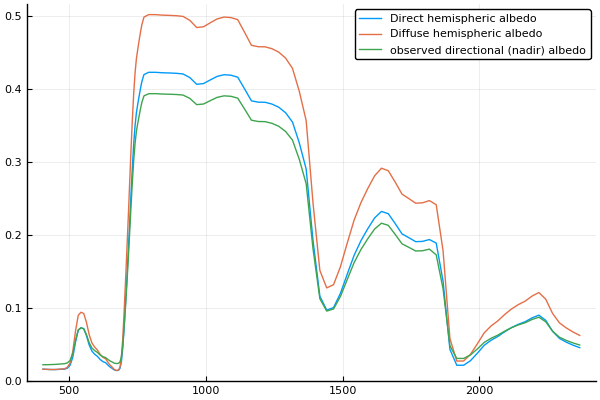

In [14]:
plot(wl,canRad.alb_direct, label="Direct hemispheric albedo")
plot!(wl,canRad.alb_diffuse, label="Diffuse hemispheric albedo")
plot!(wl,canRad.alb_obs, label="observed directional (nadir) albedo")

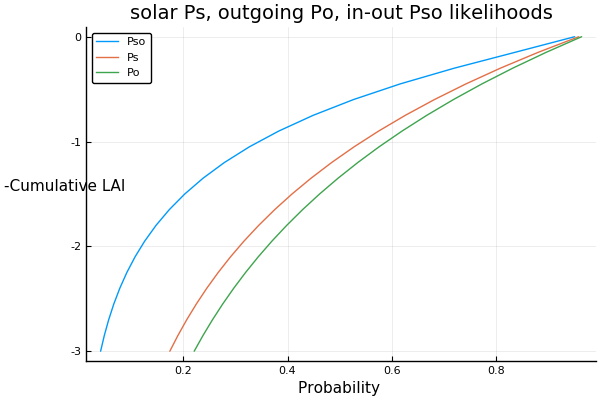

In [15]:

sumLAI = [0:iLAI:canopy.LAI;]
plot(canOpt.Pso,-sumLAI, label="Pso")
plot!(canOpt.Ps,-sumLAI, label="Ps")
plot!(canOpt.Po,-sumLAI, label="Po")
ylabel!("-Cumulative LAI")
xlabel!("Probability ")
title!("solar Ps, outgoing Po, in-out Pso likelihoods")

## Energy Balance test
need to check consistency between net TOA radiation and soil+vegetation absorption.

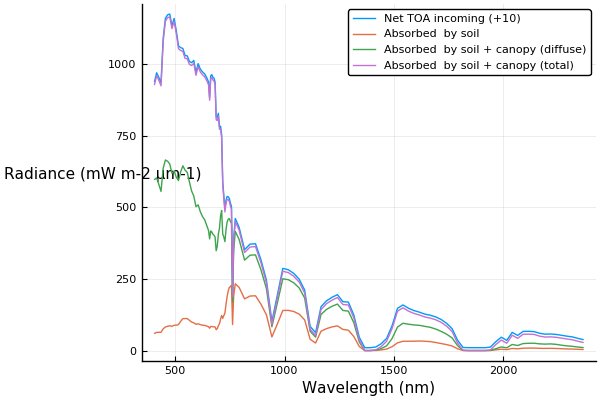

In [16]:
solar_in = sunRad.E_diffuse+sunRad.E_direct;
soil_absorbed = canRad.E_down[:,end]+canOpt.Es_[:,end]-canRad.E_up[:,end]
canopy_absorbed_diff = sum(canRad.netSW_shade, dims=2)[:,1]
canopy_absorbed_dir = sum(canRad.netSW_sunlit, dims=2)[:,1]
plot(wl,solar_in-CanopyRTMod.canRad.E_up[:,1].+10, label="Net TOA incoming (+10)")
plot!(wl,soil_absorbed, label="Absorbed  by soil")
plot!(wl,soil_absorbed+canopy_absorbed_diff, label="Absorbed  by soil + canopy (diffuse)")
plot!(wl,soil_absorbed+canopy_absorbed_diff+canopy_absorbed_dir, label="Absorbed  by soil + canopy (total)")
xlabel!("Wavelength (nm)")
ylabel!("Radiance (mW m-2 μm-1)")

### Energy balance test

In [17]:
sum(soil_absorbed+canopy_absorbed_diff+canopy_absorbed_dir-solar_in+CanopyRTMod.canRad.E_up[:,1], dims=1)

1-element StaticArrays.SArray{Tuple{1},Float32,1,1} with indices SOneTo(1):
 -0.0013868175

---
Run Fluspect, leaf optical property generator (provides reflectance and transmittance)

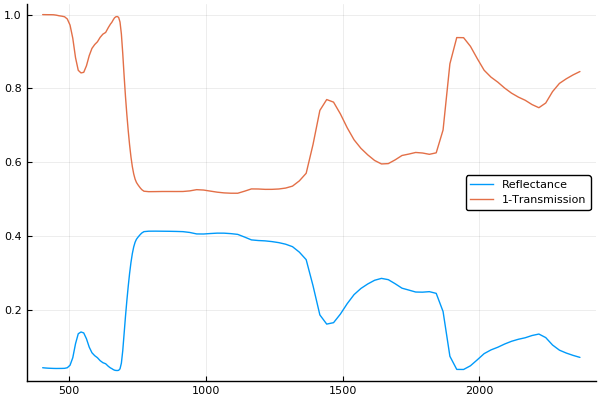

In [18]:
plot(wl, arrayOfLeaves[10].ρ_SW, label="Reflectance")
plot!(wl, 1 .-arrayOfLeaves[10].τ_SW, label="1-Transmission")

In [19]:
println("Net Soil radiation (direct): ", canRad.RnSoil_direct, "W/m2")
println("Net Soil radiation (diffuse): ", canRad.RnSoil_diffuse, "W/m2")

Net Soil radiation (direct): 51.121838W/m2
Net Soil radiation (diffuse): 60.563007W/m2


In [20]:
println("Incoming direct PAR: ", 1e6*canRad.incomingPAR_direct, "moles m^-2 s^-1")
println("Incoming diffuse PAR: ", 1e6*canRad.incomingPAR_diffuse, "moles m^-2 s^-1")

Incoming direct PAR: 890.70393005386moles m^-2 s^-1
Incoming diffuse PAR: 529.8894830048084moles m^-2 s^-1


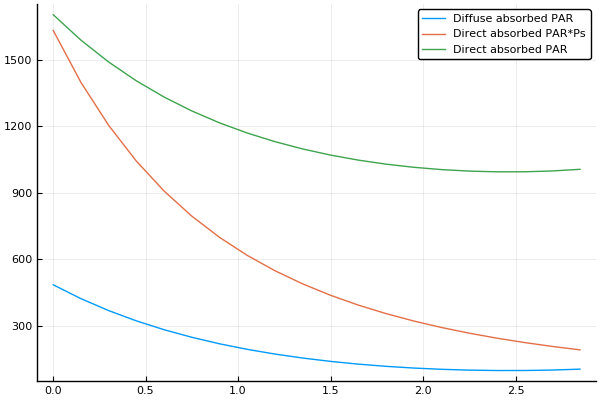

In [21]:
nl = CanopyRTMod.canopy.nlayers
#normi = 1/mean(canOpt.fs'*canopy.lidf)
plot(sumLAI[1:nl], 1e6*canRad.absPAR_shadeCab, label="Diffuse absorbed PAR")
plot!(sumLAI[1:nl], 1e6*canRad.absPAR_sunCab[5,4,:].*canOpt.Ps[1:nl], label="Direct absorbed PAR*Ps")
plot!(sumLAI[1:nl], 1e6*canRad.absPAR_sunCab[5,4,:], label="Direct absorbed PAR")

In [22]:
mean(canOpt.Ps)

0.46530446f0

#### Azimuth (x) and Inclination (y) dependence on absorbed PAR for sunlit leaves

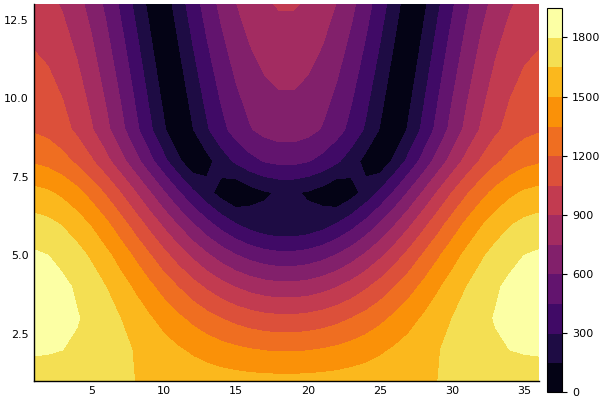

In [32]:
contourf(1e6*canRad.absPAR_sunCab[:,:,1])
#plot!(1e6*canRad.absPAR_sun[:,:,1][:])

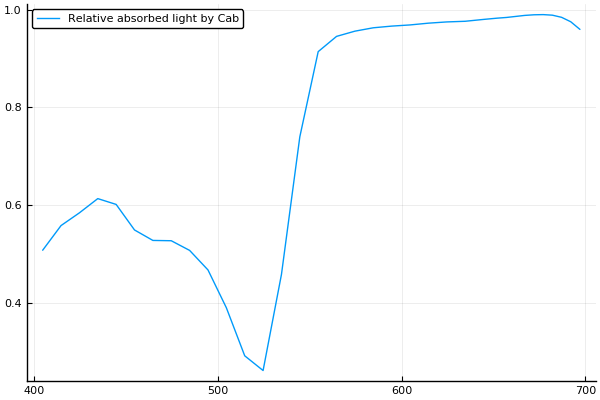

In [30]:
# plot(wl[CanopyRTMod.iPAR], arrayOfLeaves[1].kChlrel[CanopyRTMod.iPAR], label="Relative absorbed light by Cab+Car")
plot(wl[CanopyRTMod.iPAR], arrayOfLeaves[1].kChlrel_old[CanopyRTMod.iPAR], label="Relative absorbed light by Cab")


In [25]:
nwl2,nl2 = size(canOpt.R_dd)

(114, 21)

In [26]:
nwl2

114